In [1]:
import sys
sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.discrete.discrete_model import Logit

# Import et préparation des données

In [2]:
train = pd.read_csv("../data/application_train_vf.csv")
test = pd.read_csv("../data/application_test_vf.csv")

In [3]:
dataprep = DataPreparation(train, test, 0.3, plot = True)
train_prepared, test_prepared = dataprep.get_prepared_data()

Type des variables convertis ✅


KeyError: 'AMT_CREDIT_SUM_DEBT'

In [5]:
#train_prepared.to_csv("../data/train_prepared.csv")
#test_prepared.to_csv("../data/test_prepared.csv")
train_prepared = pd.read_csv("../data/train_prepared.csv", index_col=[0])
test_prepared = pd.read_csv("../data/test_prepared.csv", index_col=[0])

In [6]:
df_train = train_prepared.copy()

In [7]:
df_validation = df_train.iloc[280000:,:]
df_train = df_train.iloc[:280000,:]

# Modélisation

In [53]:
features = list(train_prepared.iloc[:,-7:].columns)

In [54]:
reference_categories = {var : train_prepared[var].mode()[0] for var in features}

In [55]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [56]:
model = Logit.from_formula(formula=formula, data=train_prepared)
logit_model = model.fit_regularized(maxiter = 500, method='l1')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2668318327789872
            Iterations: 51
            Function evaluations: 51
            Gradient evaluations: 51


# Prédiction

In [42]:
pred = logit_model.predict(df_validation)

In [43]:
pred = pred.apply(lambda x : 0 if x < 0.5 else 1)

In [44]:
confusion_matrix(pred, df_validation["TARGET"])

array([[23788,  2319],
       [    0,     0]])

/Users/axel/Documents/École/Université/M2/M2_S1/Challenge_Nexialog/venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


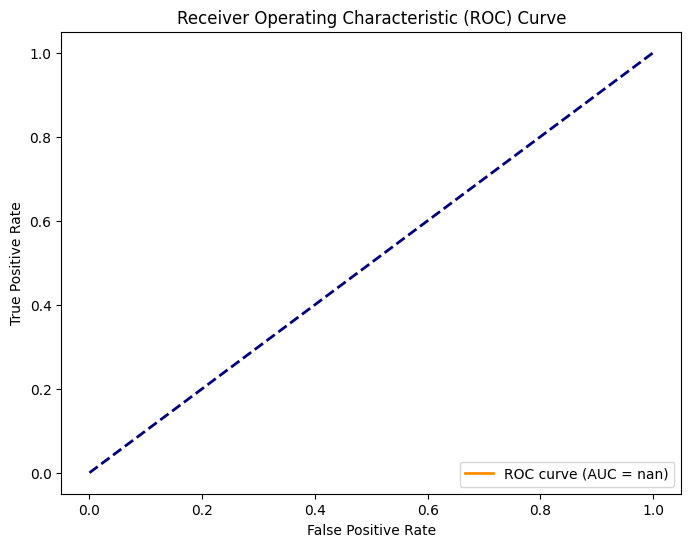

In [45]:
fpr, tpr, thresholds = roc_curve(pred, df_validation["TARGET"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [46]:
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

nan

# Grille de score

In [47]:
GS = GridScore(df_train, logit_model)
grid_score = GS.compute_grid_score()

In [58]:
logit_model.summary2().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-2.542790,0.011658,-218.108399,0.000000e+00,-2.565640,-2.519940
"C(FLAG_WORK_PHONE, Treatment(reference=""zero""))[T.un]",0.285968,0.017184,16.641398,3.493639e-62,0.252288,0.319648
"C(FLAG_PHONE, Treatment(reference=""zero""))[T.un]",-0.276432,0.016590,-16.662967,2.436317e-62,-0.308947,-0.243917
"C(LIVE_CITY_NOT_WORK_CITY, Treatment(reference=""zero""))[T.un]",0.197495,0.016893,11.690796,1.420488e-31,0.164385,0.230605
"C(NAME_CONTRACT_TYPE, Treatment(reference=""Cash loans""))[T.Revolving loans]",-0.453466,0.027566,-16.450491,8.319097e-61,-0.507494,-0.399439
"C(FLAG_OWN_CAR, Treatment(reference=""N""))[T.Y]",-0.373044,0.015758,-23.672733,6.886137e-124,-0.403930,-0.342158
"C(FLAG_OWN_REALTY, Treatment(reference=""Y""))[T.N]",-0.016116,0.014841,-1.085879,2.775325e-01,-0.045204,0.012972
"C(CODE_GENDER, Treatment(reference=""F""))[T.M]",0.496581,0.014835,33.473465,1.172893e-245,0.467505,0.525658


In [48]:
grid_score

,Variable,Modality,Coefficient,P-Value,Score,Contribution,Pcentage_Défaut,Pcentage_Classe
0,Intercept,-,-2.54279,0.0000,0.000000,0.0,0.00,0.00
1,FLAG_WORK_PHONE,zero_ref,0.00000,0.0000,137.440758,14.0,5.76,80.11
2,FLAG_WORK_PHONE,un,0.29000,0.0000,0.000000,14.0,1.80,19.89
3,FLAG_PHONE,zero_ref,0.00000,0.0000,0.000000,13.0,5.71,71.86
4,FLAG_PHONE,un,-0.28000,0.0000,132.701422,13.0,1.85,28.14
5,LIVE_CITY_NOT_WORK_CITY,zero_ref,0.00000,0.0000,94.786730,9.0,5.90,82.10
6,LIVE_CITY_NOT_WORK_CITY,un,0.20000,0.0000,0.000000,9.0,1.66,17.90
7,NAME_CONTRACT_TYPE,Cash loans_ref,0.00000,0.0000,0.000000,21.0,7.07,90.48
8,NAME_CONTRACT_TYPE,Revolving loans,-0.45000,0.0000,213.270142,21.0,0.48,9.52
9,FLAG_OWN_CAR,N_ref,0.00000,0.0000,0.000000,18.0,5.24,65.96


## Calcul des scores individuels

In [49]:
df_score = GS.get_individual_score()

(array([  2897.,   9333.,  28181.,  36510., 113993.,  18879.,  57595.,
          7132.,   4813.,    667.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <BarContainer object of 10 artists>)

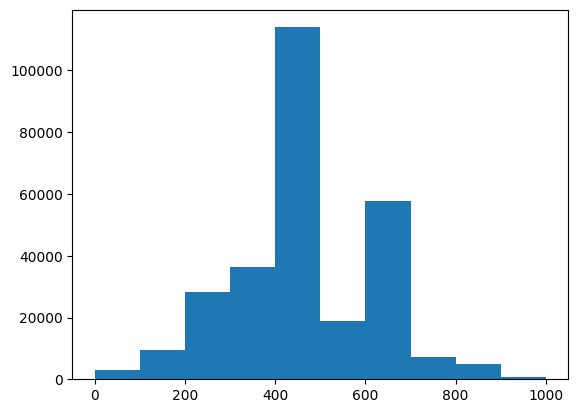

In [50]:
plt.hist(df_score["Score_ind"])

In [51]:
df_score.to_csv("../data/df_score.csv")